In [52]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/work/Data Science/sheffield-bats


In [53]:
import geopandas as gpd
import rioxarray as rxr
import xarray as xr

# Load Data

In [54]:
s2_data = xr.open_mfdataset("data/raw/big-files/sentinel-2/*", combine="by_coords")
s2_data = s2_data["band_data"]
# Set band names as google earth engine names
band_names = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]

s2_data.coords["band"] = list(s2_data.attrs["long_name"])
s2_data

<xarray.DataArray 'band_data' (band: 12, y: 8294, x: 10647)> Size: 8GB
dask.array<concatenate, shape=(12, 8294, 10647), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 85kB 3.908e+05 3.908e+05 ... 4.973e+05 4.973e+05
  * y            (y) float64 66kB 4.403e+05 4.403e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 8B 0
  * band         (band) <U3 144B 'B1' 'B2' 'B3' 'B4' ... 'B8A' 'B9' 'B11' 'B12'
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

In [55]:
dtm = rxr.open_rasterio("data/processed/dtm-10m.tif")

dtm.coords["band"] = ["dtm"]

dtm

<xarray.DataArray (band: 1, y: 42000, x: 54000)> Size: 9GB
[2268000000 values with dtype=float32]
Coordinates:
  * x            (x) float64 432kB 3.908e+05 3.908e+05 ... 4.988e+05 4.988e+05
  * y            (y) float64 336kB 4.413e+05 4.413e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 8B 0
  * band         (band) <U3 12B 'dtm'
Attributes:
    AREA_OR_POINT:    Area
    DataType:         Generic
    SourceBandIndex:  0
    _FillValue:       -9999.0
    scale_factor:     1.0
    add_offset:       0.0
    long_name:        LIDAR_Composite_2m_DTM_2022_Elevation

# Reproject and Combine

In [56]:
dtm = dtm.rio.reproject_match(s2_data)

## Normalise

In [57]:
# use mean and std to normalize
dtm = (dtm - dtm.mean()) / dtm.std()
# then normalise to 0-1
dtm = (dtm - dtm.min()) / (dtm.max() - dtm.min())

# for s2 subtract 1000 and divide by 3000
s2_data = (s2_data - 1000) / 3000
# then normalise to 0-1
s2_data = s2_data.clip(0, 1)


In [58]:
image_stack = xr.concat([s2_data, dtm], dim="band")
image_stack = image_stack.chunk({"band" : -1, "x" : 1024, "y" : 1024})
image_stack = image_stack.persist()
image_stack = image_stack.to_dataset(dim="band")
image_stack

<xarray.Dataset> Size: 9GB
Dimensions:      (y: 8294, x: 10647)
Coordinates:
  * x            (x) float64 85kB 3.908e+05 3.908e+05 ... 4.973e+05 4.973e+05
  * y            (y) float64 66kB 4.403e+05 4.403e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 8B 0
Data variables: (12/13)
    B1           (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B2           (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B3           (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B4           (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B5           (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B6           (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    ...           ...
    B8           (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B8A          (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B9           (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B11          (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B12          (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    dtm          (y, x) float64 706MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

# Visualise Bands

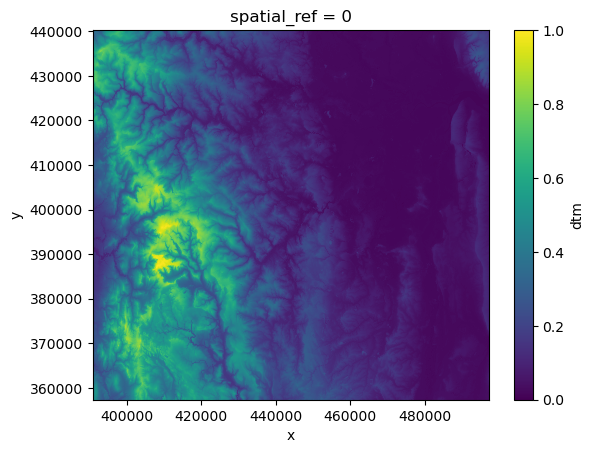

In [59]:
image_stack['dtm'].plot.imshow()

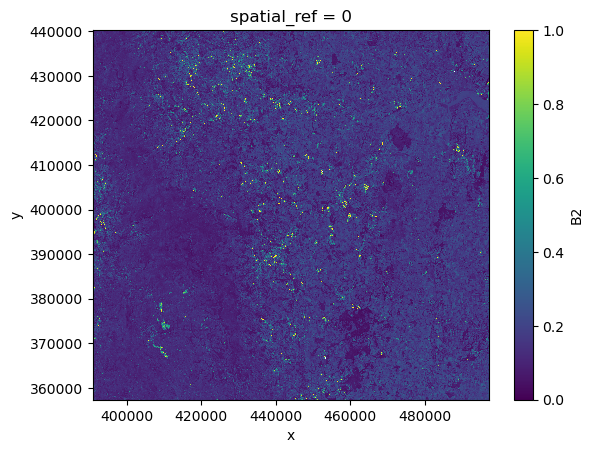

In [62]:
image_stack['B2'].plot.imshow()

# Write the data

In [63]:
image_stack.rio.to_raster("data/processed/s2-dtm-100m.tif")